In [2]:
import numpy as np
import matplotlib.pyplot as plt
import shapely

import math

import geopandas as gpd
import pandas as pd

import osmnx as ox

import os

import rasterio
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
from rasterio.features import rasterize, geometry_mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.io import MemoryFile

from shapely.geometry import box

import utils

# City Boundaries

PROJCS["CH1903+ / LV95",GEOGCS["CH1903+",DATUM["CH1903+",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6150"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4150"]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",46.9524055555556],PARAMETER["longitude_of_center",7.43958333333333],PARAMETER["azimuth",90],PARAMETER["rectified_grid_angle",90],PARAMETER["scale_factor",1],PARAMETER["false_easting",2600000],PARAMETER["false_northing",1200000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2056"]]


<Axes: >

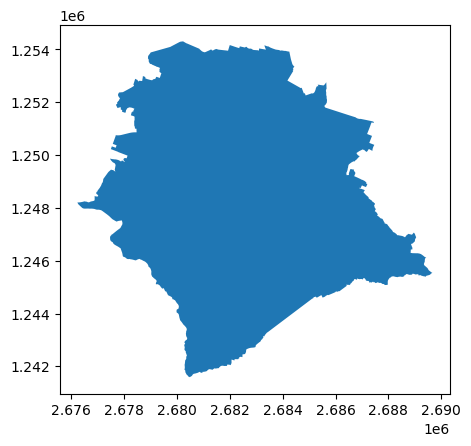

In [3]:
eu_files = "Data/UI-boundaries-FUA/FUA_Boundaries.shp" #EPSG:3035
zurich_file  = "Data/ZH/zurich_boundaries.gpkg" #EPSG:2056

num_crs = 2056
# num_crs = 3857
target_crs = rasterio.crs.CRS.from_epsg(num_crs)

CITY = "ZH"

if CITY == "ZH":
    city_gdf = gpd.read_file(zurich_file)
    city_gdf.set_crs("EPSG:2056", inplace=True, allow_override=True)

    # save as shapefile
    city_gdf.to_file("../SSANTO Data/Boundary/zurich_boundaries.shp")
    city_gdf = city_gdf.to_crs(target_crs)
    print(city_gdf.crs)

elif CITY == "BCN":
    city_gdf = gpd.read_file(eu_files)
    city_gdf = city_gdf.loc[city_gdf['FUA_NAME'] == 'Barcelona']

    city_gdf = city_gdf.to_crs(target_crs)

elif CITY == "VIE":
    city_gdf = gpd.read_file(eu_files)
    city_gdf = city_gdf.loc[city_gdf['FUA_NAME'] == 'Wien']

    city_gdf = city_gdf.to_crs(target_crs)


city_gdf.plot()

In [319]:
# Save boundary as a shapefile
city_gdf.to_file(f"Data/{CITY}/polygon.shp")

# Define Target Parameters

In [3]:
# define resolution and target CRS
target_resolution_meters = 30 
target_crs = rasterio.crs.CRS.from_epsg(num_crs)

# Get resolution in degrees
# Calculate degrees per 100 meters based on latitude
# # Assume a representative latitude for the dataset
# representative_latitude = 47.37
# latitude_degree_in_meters = 111132  # 1 degree latitude in meters (constant)
# longitude_degree_in_meters = latitude_degree_in_meters * math.cos(math.radians(representative_latitude))

# # Convert meters to degrees for latitude and longitude
# resolution_lat = target_resolution_meters / latitude_degree_in_meters
# resolution_lon = target_resolution_meters / longitude_degree_in_meters


# LULC Dataset

In [4]:
# Step 1: load the LULC vector dataset

if CITY == 'ZH':
    lulc_file = "Data/ZH/CH001L2_ZURICH_UA2018_v013/Data/CH001L2_ZURICH_UA2018_v013.gpkg"
elif CITY == 'BCN':
    lulc_file = "Data/BCN/ES002L2_BARCELONA_UA2018_v013/Data/ES002L2_BARCELONA_UA2018_v013.gpkg"
elif CITY == 'VIE':
    lulc_file = "Data/VIE/AT001L3_WIEN_UA2018_v013/Data/AT001L3_WIEN_UA2018_v013.gpkg"

lulc_gdf = gpd.read_file(lulc_file)
print(lulc_gdf.crs)

EPSG:3035


In [8]:
buffer_size = 10000
city_gdf_buffered = city_gdf.copy()
city_gdf_buffered["geometry"] = city_gdf.buffer(buffer_size)

In [368]:
lulc_gdf = lulc_gdf.to_crs(target_crs)
lulc_gdf['code_2018'] = lulc_gdf['code_2018'].astype(int)

In [ ]:
# Define EXECUTE_MASK flag
EXECUTE_MASK = True

# Step 1: Calculate bounding box and raster dimensions
bounds = lulc_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
width = math.ceil((bounds[2] - bounds[0]) / target_resolution_meters)  # Width in pixels
height = math.ceil((bounds[3] - bounds[1]) / target_resolution_meters)  # Height in pixels
print(f"Raster dimensions: {width} x {height}")

# Step 2: Calculate the transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Step 3: Rasterize the vector data into the target CRS
rasterized = rasterize(
    ((geom, value) for geom, value in zip(lulc_gdf.geometry, lulc_gdf['code_2018'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Value for areas with no data
    dtype="uint16",
)

if EXECUTE_MASK:

    # Step 4: Save rasterized data to an in-memory file and apply mask
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype="uint16",
            crs=target_crs,
            transform=transform,
        ) as dataset:
            dataset.write(rasterized, 1)  # Write the rasterized layer to band 1

            # Mask the dataset using city_gdf geometry
            masked_raster, mask_transform = mask(
                dataset,
                city_gdf_buffered.geometry,
                crop=True,
                nodata=0
            )
        
        # Step 5: Update metadata for the cropped raster
        cropped_meta = {
            "driver": "GTiff",
            "height": masked_raster.shape[1],
            "width": masked_raster.shape[2],
            "count": 1,
            "dtype": "uint16",
            "crs": target_crs,
            "transform": mask_transform,
        }

    # Step 6: Save the final masked raster
    output_path = f"Data/{CITY}/lulc_raster_{target_resolution_meters}m.tif"
    with rasterio.open(output_path, "w", **cropped_meta) as dst:
        dst.write(masked_raster[0], 1)

    print(f"Final cropped raster saved to: {output_path}")

else:
    # Save the unmasked raster directly
    output_path = f"Data/{CITY}/lulc_raster_{target_resolution_meters}m_3857_full.tif"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="uint16",
        crs=target_crs,
        transform=transform,
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Unmasked raster saved to: {output_path}")


Raster dimensions: 1568 x 1802


### Industry

In [326]:
industry_gdf = lulc_gdf.loc[lulc_gdf['code_2018'] == '12100']
industry_gdf = industry_gdf.to_crs(target_crs)
industry_gdf['code_2018'] = industry_gdf['code_2018'].astype(int)

In [224]:
# Define mask flag
EXECUTE_MASK = True

# Step 1: Calculate bounding box and raster dimensions
bounds = industry_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
width = math.ceil((bounds[2] - bounds[0]) / target_resolution_meters)  # Width in pixels
height = math.ceil((bounds[3] - bounds[1]) / target_resolution_meters)  # Height in pixels
print(f"Raster dimensions: {width} x {height}")

# Step 2: Calculate the transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Step 3: Rasterize the vector data into the target CRS
rasterized = rasterize(
    ((geom, value) for geom, value in zip(industry_gdf.geometry, industry_gdf['code_2018'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Value for areas with no data
    dtype="uint16",
)

if EXECUTE_MASK:
    # Step 4: Save rasterized data to an in-memory file and apply mask
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype="uint16",
            crs=target_crs,
            transform=transform,
        ) as dataset:
            dataset.write(rasterized, 1)  # Write the rasterized layer to band 1

            # Mask the dataset using city_gdf geometry
            masked_raster, mask_transform = mask(
                dataset,
                city_gdf.geometry,
                crop=True,
                nodata=0
            )
        
        # Step 5: Update metadata for the cropped raster
        cropped_meta = {
            "driver": "GTiff",
            "height": masked_raster.shape[1],
            "width": masked_raster.shape[2],
            "count": 1,
            "dtype": "uint16",
            "crs": target_crs,
            "transform": mask_transform,
        }

    # Step 6: Save the final masked raster
    output_path = f"Data/{CITY}/ind_raster_{target_resolution_meters}m.tif"
    with rasterio.open(output_path, "w", **cropped_meta) as dst:
        dst.write(masked_raster[0], 1)

    print(f"Final cropped raster saved to: {output_path}")

else:
    # Save the unmasked raster directly
    output_path = f"Data/{CITY}/ind_raster_{target_resolution_meters}m_full.tif"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="uint16",
        crs=target_crs,
        transform=transform,
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Unmasked raster saved to: {output_path}")


Raster dimensions: 1209 x 1277
Unmasked raster saved to: Data/VIE/ind_raster_100m_full.tif


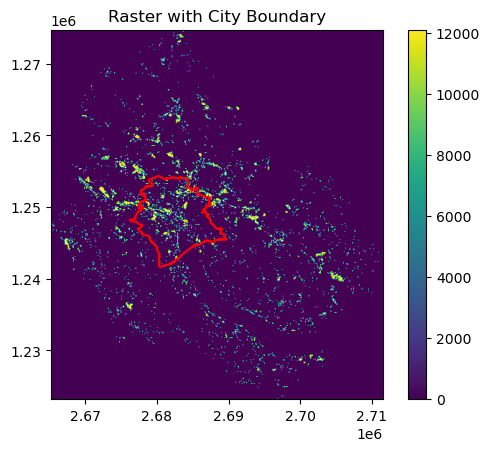

Class counts:
0        233266
12100      6158
Name: count, dtype: int64
CRS: EPSG:2056


In [ ]:
# Test opening the raster and reading the data
with rasterio.open(f"Data/{CITY}/ind_raster_{target_resolution_meters}m_full.tif") as src:
    
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

    ind_raster = src.read(1)
    ind_extent = extent
    
    plt.imshow(src.read(1), cmap='viridis', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='red')
    plt.colorbar()
    plt.title("Raster with City Boundary")
    plt.show()

    # Print counts of each class
    print("Class counts:")
    print(pd.Series(src.read(1).ravel()).value_counts())

    print("CRS:", src.crs)

### Residential

In [9]:
res_gdf = lulc_gdf.loc[(lulc_gdf['code_2018'] >= '11100') & (lulc_gdf['code_2018'] <= '11300') | (lulc_gdf['code_2018'] == '12100')]
res_gdf = res_gdf.to_crs(target_crs)
res_gdf['code_2018'] = res_gdf['code_2018'].astype(int)
print(res_gdf.crs)

PROJCS["CH1903+ / LV95",GEOGCS["CH1903+",DATUM["CH1903+",SPHEROID["Bessel 1841",6377397.155,299.1528128,AUTHORITY["EPSG","7004"]],AUTHORITY["EPSG","6150"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4150"]],PROJECTION["Hotine_Oblique_Mercator_Azimuth_Center"],PARAMETER["latitude_of_center",46.9524055555556],PARAMETER["longitude_of_center",7.43958333333333],PARAMETER["azimuth",90],PARAMETER["rectified_grid_angle",90],PARAMETER["scale_factor",1],PARAMETER["false_easting",2600000],PARAMETER["false_northing",1200000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","2056"]]


In [12]:
# Define EXECUTE_MASK flag
EXECUTE_MASK = True

# Step 1: Calculate bounding box and raster dimensions
bounds = res_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
width = math.ceil((bounds[2] - bounds[0]) / target_resolution_meters)  # Width in pixels
height = math.ceil((bounds[3] - bounds[1]) / target_resolution_meters)  # Height in pixels
print(f"Raster dimensions: {width} x {height}")

# Step 2: Calculate the transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Step 3: Rasterize the vector data into the target CRS
rasterized = rasterize(
    ((geom, value) for geom, value in zip(res_gdf.geometry, res_gdf['code_2018'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Value for areas with no data
    dtype="uint16",
)

if EXECUTE_MASK:
    # Step 4: Save rasterized data to an in-memory file and apply mask
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype="uint16",
            crs=target_crs,
            transform=transform,
        ) as dataset:
            dataset.write(rasterized, 1)  # Write the rasterized layer to band 1

            # Mask the dataset using city_gdf geometry
            masked_raster, mask_transform = mask(
                dataset,
                city_gdf_buffered.geometry,
                crop=True,
                nodata=0
            )
        
        # Step 5: Update metadata for the cropped raster
        cropped_meta = {
            "driver": "GTiff",
            "height": masked_raster.shape[1],
            "width": masked_raster.shape[2],
            "count": 1,
            "dtype": "uint16",
            "crs": target_crs,
            "transform": mask_transform,
        }

    # Step 6: Save the final masked raster
    output_path = f"Data/{CITY}/res_ind_raster_{target_resolution_meters}m_full.tif"
    with rasterio.open(output_path, "w", **cropped_meta) as dst:
        dst.write(masked_raster[0], 1)

    print(f"Final cropped raster saved to: {output_path}")

else:
    # Save the unmasked raster directly
    output_path = f"Data/{CITY}/res_raster_{target_resolution_meters}m_full.tif"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="uint16",
        crs=target_crs,
        transform=transform,
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Unmasked raster saved to: {output_path}")


Raster dimensions: 1561 x 1756
Final cropped raster saved to: Data/ZH/res_ind_raster_30m_full.tif


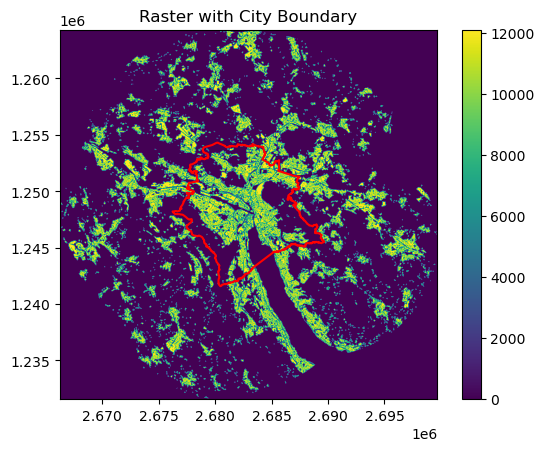

Value counts:
{0: 1023713, 11100: 5603, 11210: 32426, 11220: 70161, 11230: 25794, 11240: 4473, 11300: 6645, 12100: 49857}



In [13]:
# Test opening the raster and reading the data
with rasterio.open(f"Data/{CITY}/res_ind_raster_{target_resolution_meters}m_full.tif") as src:
# with rasterio.open(f"../SSANTO Data/Landcover/res_ind_raster_{target_resolution_meters}m_3857.tif") as src:

    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

    res_raster = src.read(1)
    res_extent = extent
    
    plt.imshow(src.read(1), cmap='viridis', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='red')
    plt.colorbar()
    plt.title("Raster with City Boundary")
    plt.show()

    # print statistics of the raster (most common values)
    band1 = src.read(1)
    unique, counts = np.unique(band1, return_counts=True)
    print("Value counts:")
    print(dict(zip(unique, counts)))

    print()
    


# Other LULC Types 
Needed for the conditions of allocations of emissions (mostly urban green areas and forests)


In [230]:
misc_codes = ['14100', '31000', '32000', '33000']
# 14100: green urban areas
# 31000: forests
# 32000: vegatation
# 33000: open spaces with little or no vegetation

misc_lulc_gdf = lulc_gdf.loc[lulc_gdf['code_2018'].isin(misc_codes)]
misc_lulc_gdf = misc_lulc_gdf.to_crs(target_crs)
misc_lulc_gdf['code_2018'] = misc_lulc_gdf['code_2018'].astype(int)


In [231]:
import math
from rasterio import MemoryFile
from rasterio.features import rasterize
from rasterio.mask import mask
import rasterio

# Define EXECUTE_MASK flag
EXECUTE_MASK = False

# Step 1: Calculate bounding box and raster dimensions
bounds = misc_lulc_gdf.total_bounds  # [xmin, ymin, xmax, ymax]
width = math.ceil((bounds[2] - bounds[0]) / target_resolution_meters)  # Width in pixels
height = math.ceil((bounds[3] - bounds[1]) / target_resolution_meters)  # Height in pixels
print(f"Raster dimensions: {width} x {height}")

# Step 2: Calculate the transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Step 3: Rasterize the vector data into the target CRS
rasterized = rasterize(
    ((geom, value) for geom, value in zip(misc_lulc_gdf.geometry, misc_lulc_gdf['code_2018'])),
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Value for areas with no data
    dtype="uint16",
)

if EXECUTE_MASK:
    # Step 4: Save rasterized data to an in-memory file and apply mask
    with MemoryFile() as memfile:
        with memfile.open(
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype="uint16",
            crs=target_crs,
            transform=transform,
        ) as dataset:
            dataset.write(rasterized, 1)  # Write the rasterized layer to band 1

            # Mask the dataset using city_gdf geometry
            masked_raster, mask_transform = mask(
                dataset,
                city_gdf.geometry,
                crop=True,
                nodata=0
            )
        
        # Step 5: Update metadata for the cropped raster
        cropped_meta = {
            "driver": "GTiff",
            "height": masked_raster.shape[1],
            "width": masked_raster.shape[2],
            "count": 1,
            "dtype": "uint16",
            "crs": target_crs,
            "transform": mask_transform,
        }

    # Step 6: Save the final masked raster
    output_path = f"Data/{CITY}/misc_lulc_raster_{target_resolution_meters}m.tif"
    with rasterio.open(output_path, "w", **cropped_meta) as dst:
        dst.write(masked_raster[0], 1)

    print(f"Final cropped raster saved to: {output_path}")

else:
    # Save the unmasked raster directly
    output_path = f"Data/{CITY}/misc_lulc_raster_{target_resolution_meters}m_full.tif"
    with rasterio.open(
        output_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="uint16",
        crs=target_crs,
        transform=transform,
    ) as dst:
        dst.write(rasterized, 1)

    print(f"Unmasked raster saved to: {output_path}")

Raster dimensions: 1223 x 1307
Unmasked raster saved to: Data/VIE/misc_lulc_raster_100m_full.tif


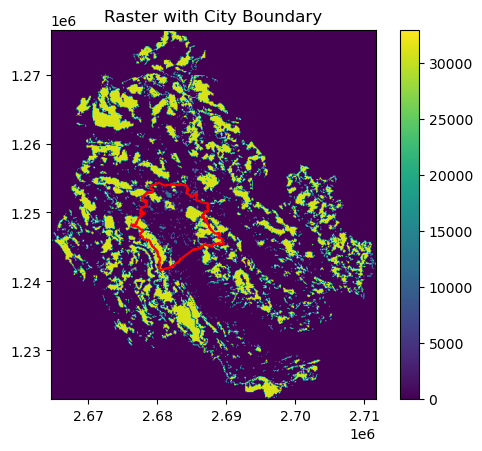

Value counts:
{0: 215404, 14100: 929, 31000: 36357, 32000: 763, 33000: 11}


In [270]:
# Test opening the raster and reading the data
with rasterio.open(f"Data/{CITY}/misc_lulc_raster_{target_resolution_meters}m_full.tif") as src:
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]


    plt.imshow(src.read(1), cmap='viridis', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='red')
    plt.colorbar()
    plt.title("Raster with City Boundary")
    plt.show()

    # print statistics of the raster (most common values)
    band1 = src.read(1)
    unique, counts = np.unique(band1, return_counts=True)
    print("Value counts:")
    print(dict(zip(unique, counts)))
    


# Transport

In [156]:
# Load Graph from open street map (takes time and fetches from API)
G = ox.load_graphml(f"Data/{CITY}/street_map.graphml")

In [274]:
# Preprocess the graph
_, edges = ox.graph_to_gdfs(G)
projected_edges = edges.to_crs(target_crs)

# Step 1: Calculate bounding box and raster dimensions
bounds = projected_edges.total_bounds  # [xmin, ymin, xmax, ymax]
width = math.ceil((bounds[2] - bounds[0]) / target_resolution_meters)  # Width in pixels
height = math.ceil((bounds[3] - bounds[1]) / target_resolution_meters)  # Height in pixels

# Step 2: Calculate the transform
transform = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], width, height)

# Step 3: Rasterize the vector data into the target CRS
rasterized = rasterize(
    [(geom, 1) for geom in projected_edges.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0,  # Value for areas with no data
    dtype="uint8",
)

output_path = f"Data/{CITY}/road_raster_{target_resolution_meters}m.tif"
with rasterio.open(
    output_path,
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype="uint8",
    crs=target_crs,
    transform=transform,
) as dst:
    dst.write(rasterized, 1)
    
print("CRS of the raster:", target_crs)
print(f"Resolution of the raster: {target_resolution_meters} meters")
print(f"Reprojected raster saved to: {output_path}")

CRS of the raster: EPSG:2056
Resolution of the raster: 100 meters
Reprojected raster saved to: Data/ZH/road_raster_100m.tif


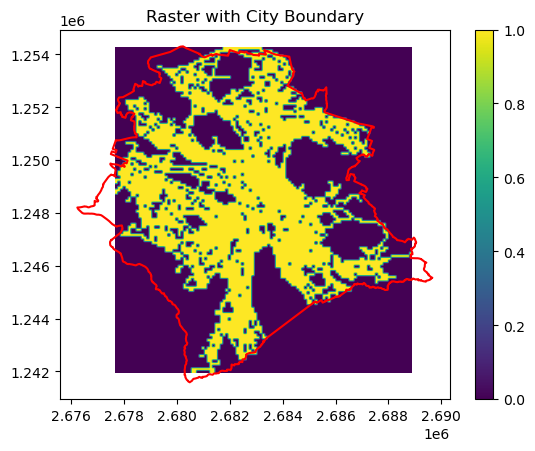

In [275]:
with rasterio.open(f"Data/{CITY}/road_raster_{target_resolution_meters}m.tif") as src:
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

    road_raster = src.read(1)
    road_extent = extent
    
    plt.imshow(src.read(1), cmap='viridis', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='red')
    plt.colorbar()
    plt.title("Raster with City Boundary")
    plt.show()

    # print statistics of the raster (most common values)

# Population

Reproject EU raster

In [236]:
target_crs = rasterio.crs.CRS.from_epsg(num_crs)

In [237]:
pop_raster = "Data/Eurostat_Census-GRID_2021_V1-0/ESTAT_OBS-VALUE-T_2021_V1-0.tiff"
# scale_factor = 10 # Resolution is 1km, so we need to scale it by 10 from the 100m resolution

# Open the input raster
with rasterio.open(pop_raster) as src:
    # Calculate the transform and new dimensions using the custom resolution
    transform, width, height = calculate_default_transform(
        src.crs,
        target_crs,
        src.width,
        src.height,
        *src.bounds,
        resolution=(1000, 1000)
    )
    
    
    print(f"Pop before reprojection: {src.read(1).sum()}")

    # Update the profile with the new CRS, transform, and resolution
    profile = src.profile
    profile.update(
        crs=target_crs,
        transform=transform,
        width=width,
        height=height,
        nodata=0  # Adjust nodata if your data requires it
    )
    
    output_file = f"Data/Pop_Density_{num_crs}.tif"
    # Perform the reprojection
    with rasterio.open(output_file, 'w', **profile) as dst:
        reproject(
            source=rasterio.band(src, 1),
            destination=rasterio.band(dst, 1),
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=transform,
            dst_crs=target_crs,
            resampling=Resampling.nearest
        )


Pop before reprojection: 437995456.0


Mask raster of the city

In [238]:
with rasterio.open(output_file) as src:
    city_gdf.to_crs(target_crs)

    # buffer the city boundary by 1 km
    city_gdf_buffered = city_gdf.copy()
    city_gdf_buffered["geometry"] = city_gdf.buffer(0.005)

    # Mask the raster with the buffered city geometry
    out_image, out_transform = mask(src, shapes=[city_gdf_buffered.geometry.values[0].__geo_interface__], crop=True, nodata=0)

    # Extract dimensions from the output image
    # out_image shape is (bands, height, width)
    _, height, width = out_image.shape

 # Create a copy of the source profile and update it
    profile = src.profile.copy()
    profile.update(
        transform=out_transform,
        width=width,
        height=height,
        # If needed, set nodata:
        nodata=0 
    )

    output_path = f"Data/{CITY}/pop.tif"
    # Write the masked raster to a new file
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(out_image)

    print(f"Masked raster saved to: {output_path}")

Masked raster saved to: Data/VIE/pop.tif


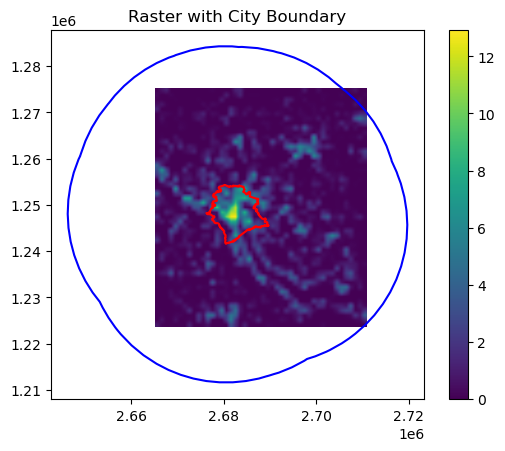

Total population: 1898809.9


In [271]:
with rasterio.open(f"Data/{CITY}/pop.tif") as src:
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]
    
    plt.imshow(src.read(1), cmap='viridis', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='red')
    city_gdf_buffered.boundary.plot(ax=plt.gca(), color='blue')
    plt.colorbar()
    plt.title("Raster with City Boundary")
    plt.show()

    # print statistics of the raster (most common values)
    band1 = src.read(1)
    unique, counts = np.unique(band1, return_counts=True)
    print("Total population:", np.sum(band1))

# Emissions

### Reprojecting carbon rasters into 3035


In [51]:
# File paths
trans = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_transport_v1.0.asc"
res = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_resident_v1.0.asc"
ind = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_industry_v1.0.asc"
carbon_grids = [trans, res, ind]

# Define CRS
assigned_crs = rasterio.CRS.from_epsg(4326)  # WGS84

for input_file, em_type in zip(carbon_grids, ["trans", "res", "ind"]):
    output_file = f"Data/GID/{em_type}_4326.tif"
    try:
        with rasterio.open(input_file) as src:
            # Define metadata with assigned CRS
            kwargs = src.meta.copy()
            kwargs.update({'crs': assigned_crs, 'driver': 'GTiff'})

            # Save the raster with assigned CRS
            with rasterio.open(output_file, 'w', **kwargs) as dst:
                dst.write(src.read(1), 1)  # Write single band
            print(f"Assigned CRS to {em_type} and saved to {output_file}")

    except Exception as e:
        print(f"Error assigning CRS to {em_type}: {e}")

Assigned CRS to trans and saved to Data/GID/trans_4326.tif
Assigned CRS to res and saved to Data/GID/res_4326.tif
Assigned CRS to ind and saved to Data/GID/ind_4326.tif


In [240]:
# Reproject each raster
target_crs = rasterio.CRS.from_epsg(num_crs)      # ETRS89-LAEA (Target CRS)

input_files = [
    f"Data/GID/{em_type}_4326.tif" for em_type in ["trans", "res", "ind"]
]

for input_file in input_files:
    em_type = os.path.basename(input_file).split("_")[0]
    reprojected_file = f"Data/GID/{em_type}_{num_crs}.tif"
    
    try:
        with rasterio.open(input_file) as src:
            # Calculate transform and dimensions for the target CRS
            transform, width, height = calculate_default_transform(
                src.crs, crs_3035, src.width, src.height, *src.bounds
            )

            # Update metadata for the reprojected file
            kwargs = src.meta.copy()
            kwargs.update({
                'crs': target_crs,
                'transform': transform,
                'width': width,
                'height': height,
                'driver': 'GTiff',
                'nodata': src.nodata 
            })

            # Create and write the reprojected raster
            with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
                reproject(
                    source=rasterio.band(src, 1),  # Single band source
                    destination=rasterio.band(dst, 1),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.sum  # Adjust resampling method as needed
                )
            print(f"Successfully reprojected {em_type} to {reprojected_file}")
    
    except Exception as e:
        print(f"Error reprojecting {em_type}: {e}")


Successfully reprojected trans to Data/GID/trans_3035.tif
Successfully reprojected res to Data/GID/res_3035.tif
Successfully reprojected ind to Data/GID/ind_3035.tif


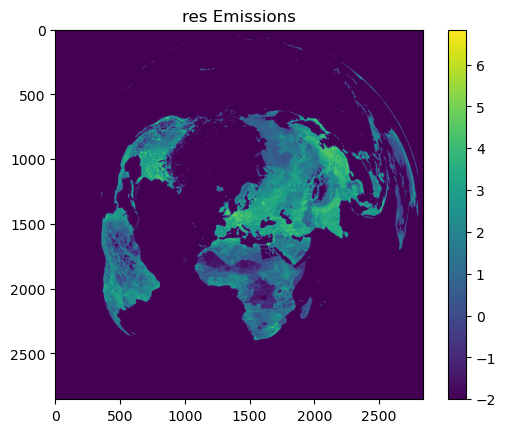

Resolution: (8924.590390315147, 8924.590390315147)
CRS: EPSG:3035


In [241]:
em_type = "res"
with rasterio.open(f"Data/GID/{em_type}_{num_crs}.tif") as src:
    # plot raster and resolution
    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]
    raster_safe = np.where(src.read(1) > 0, src.read(1), 0)
    plt.imshow(np.log10(raster_safe+.01), cmap='viridis')
    plt.colorbar()
    plt.title(f"{em_type} Emissions")
    plt.show()
    print("Resolution:", src.res)
    print("CRS:", src.crs)

### Inspecting the data

Total emissions in trans grid: 1260686.0
Total emissions in the grid: 1260686.0


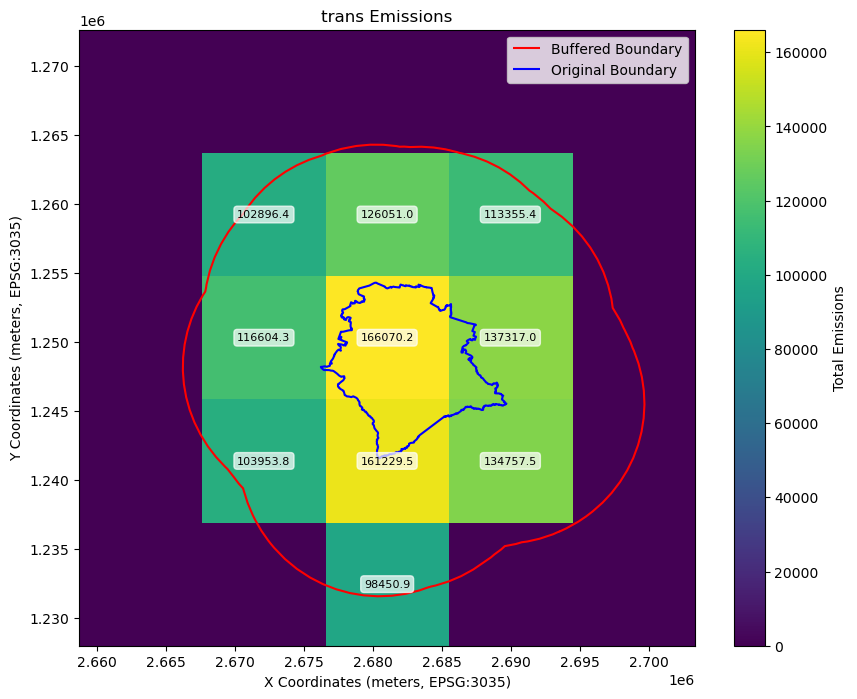

Total emissions in res grid: 2045043.2
Total emissions in the grid: 2045043.2


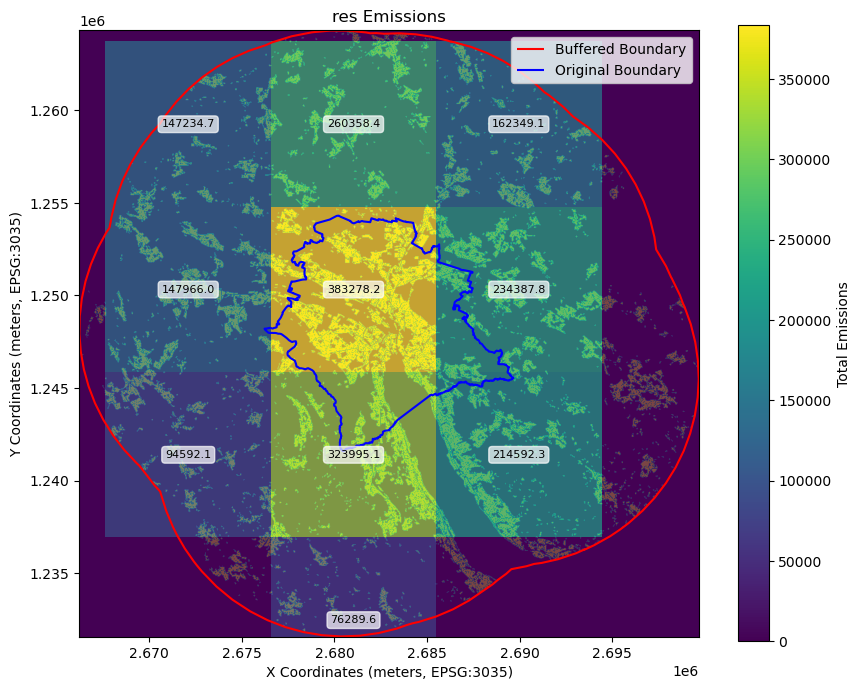

Total emissions in ind grid: 812877.6
Total emissions in the grid: 812877.6


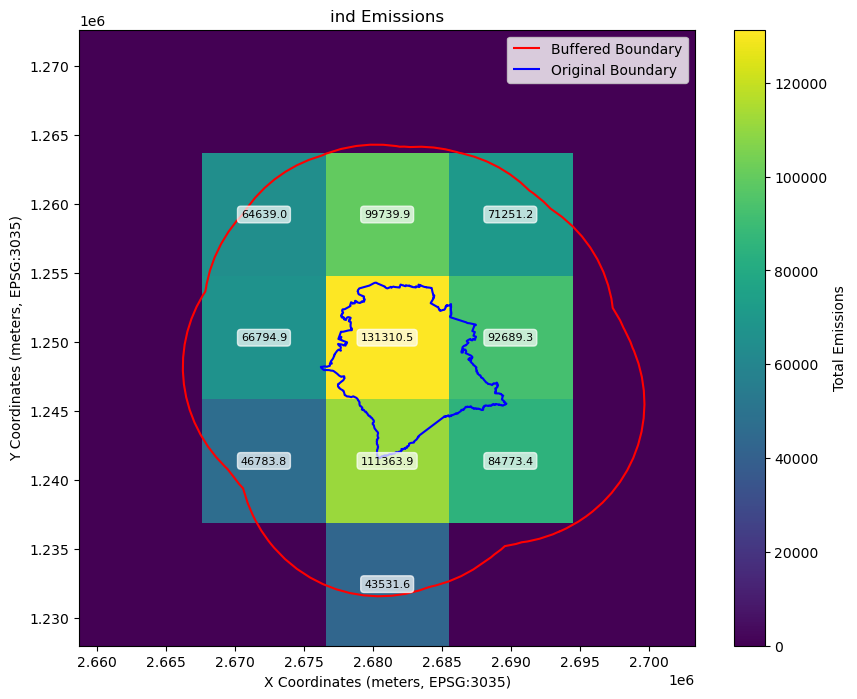

In [375]:
# trans = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_transport_v1.0.asc"  # Replace with your actual file path
# res = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_resident_v1.0.asc"  # Replace with your actual file path
# ind = "Data/GlobalCarbonGrid_v1.0/GlobalCarbonGrid_industry_v1.0.asc"  # Replace with your actual file path
trans = "Data/GID/trans_2056.tif"
res = "Data/GID/res_2056.tif"
ind = "Data/GID/ind_2056.tif"

carbon_grids = [trans, res, ind]

# city_gdf.to_crs(crs_3035, inplace=True)

# Default CRS from input files
# assigned_crs = rasterio.CRS.from_epsg(4326)
target_crs = rasterio.crs.CRS.from_epsg(2056)

city_gdf.to_crs(target_crs, inplace=True) 
city_gdf_buffered.to_crs(target_crs, inplace=True)

# city_extent = city_gdf.total_bounds
test_rasters = {"trans": (None, None), "res": (res_raster, res_extent), "ind": (None, None)}

for input_file, title in zip(carbon_grids, ["trans", "res", "ind"]):
    with rasterio.open(input_file, crs=target_crs) as src:

        out_image, out_transform = mask(src, city_gdf_buffered.geometry, crop=True)
        mask_extent = calculate_mask_extent(out_transform, out_image[0].shape)

        # Replace invalid values with a small positive value
        band1 = out_image[0]
        carbon_grid_safe = np.where(band1 > 0, band1, 0)

        print(f"Total emissions in {title} grid: {carbon_grid_safe.sum():.1f}")

        plot_carbon_grid_with_annotations(
            carbon_grid_safe=carbon_grid_safe,
            mask_extent=mask_extent,
            city_gdf=city_gdf,
            city_gdf_buffered=city_gdf_buffered,
            emission_type=title,
            out_transform=out_transform,
            test_raster=test_rasters[title][0],
            test_extent=test_rasters[title][1]
        )


In [81]:
def calculate_mask_extent(out_transform, band_shape):
    """Calculate the extent of the raster after masking."""
    return [
        out_transform[2],  # min x (left)
        out_transform[2] + out_transform[0] * band_shape[1],  # max x (right)
        out_transform[5] + out_transform[4] * band_shape[0],  # max y (top)
        out_transform[5],  # min y (bottom)
    ]


def annotate_square_sums(ax, carbon_grid_safe, out_transform):
    """
    Annotate each square of the carbon grid with the total sum of emissions.

    Args:
        ax: Matplotlib axis to plot on.
        carbon_grid_safe: 2D array of valid carbon grid values.
        out_transform: Affine transform of the masked raster.
    """
    from rasterio.transform import rowcol, xy

    grid_height, grid_width = carbon_grid_safe.shape

    for row in range(grid_height):
        for col in range(grid_width):
            cell_value = carbon_grid_safe[row, col]
            # Skip annotation for cells with near-zero values
            if cell_value < 1e-1:
                continue
            
            # Use the affine transform to calculate the center of the cell
            x_center, y_center = xy(out_transform, row, col, offset="center")

            # Annotate the value
            ax.text(
                x_center, y_center,
                f"{cell_value:.1f}",  # Adjust precision as needed
                color="black",
                fontsize=8,
                ha="center",
                va="center",
                bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="white", alpha=0.7)
            )

    print(f"Total emissions in the grid: {carbon_grid_safe.sum():.1f}")




def plot_carbon_grid_with_annotations(carbon_grid_safe, mask_extent, city_gdf, emission_type, out_transform, city_gdf_buffered=None, test_raster=None, test_extent=None):
    """Plot the carbon grid with square annotations and city boundaries."""
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot the carbon grid
    im = ax.imshow(
        carbon_grid_safe,
        cmap="viridis",
        extent=mask_extent,
    )

    # Annotate each square with its sum
    annotate_square_sums(ax, carbon_grid_safe, out_transform)

    # Plot boundaries
    if city_gdf_buffered is not None:
        city_gdf_buffered.boundary.plot(ax=ax, color="red", label="Buffered Boundary")

        
    city_gdf.boundary.plot(ax=ax, color="blue", label="Original Boundary")

    # Overlay a test road layer (if available)
    if test_raster is not None:
        ax.imshow(test_raster, alpha=0.3, extent=test_extent)

    # Add a colorbar, title, and labels
    plt.colorbar(im, label="Total Emissions")
    plt.title(f"{emission_type} Emissions")
    plt.xlabel("X Coordinates (meters, EPSG:3035)")
    plt.ylabel("Y Coordinates (meters, EPSG:3035)")
    plt.legend()
    plt.show()

# View High Res Emission Grids

Scaling factor: 5.30777507111997
Total Residential emissions: 895.867 kt CO2


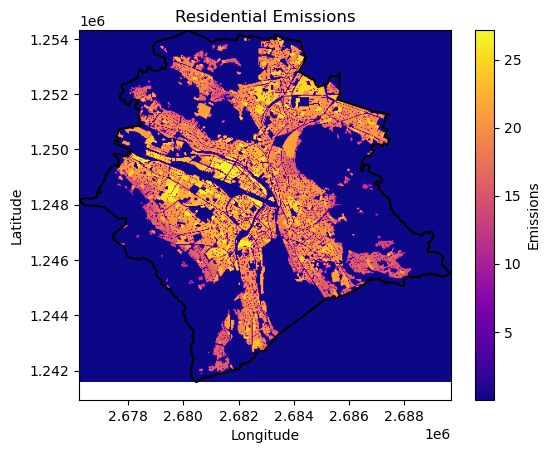

Total emissions: 895.86707 kt CO2
Resolution: (30.0, 30.0)
Quantiles:
[14.35249161 19.23569679 20.39937973 22.97665215 25.11657524 25.57265472
 27.15325737]
Unique values with counts
0.000000     146659
25.144581       281
19.542919       271
19.507051       247
19.515287       238
              ...  
22.499195         1
22.470499         1
24.643955         1
15.464746         1
14.464238         1
Name: count, Length: 4795, dtype: int64
CRS EPSG:2056


In [8]:
em_type = "res"

with rasterio.open(f"Results/{CITY}/{em_type}_ind_high_res.tif") as src:
    res_raster = src.read(1)
    raster_safe = np.where(res_raster < 0 , 0, res_raster)
    raster_safe = np.where(np.isnan(raster_safe), 0, raster_safe)
    res_meta = src.meta

    total_emissions = 895867.01 # t 

    scaling_factor = total_emissions / np.sum(raster_safe)
    print("Scaling factor:", scaling_factor)

    raster_safe = raster_safe * scaling_factor

    extent = [
        src.bounds.left,
        src.bounds.right,
        src.bounds.bottom,
        src.bounds.top
    ]

    print("Total Residential emissions:", np.sum(raster_safe) / 1e3, "kt CO2")
    plt.imshow((raster_safe + 0.01), cmap='plasma', extent=extent)
    city_gdf.boundary.plot(ax=plt.gca(), color='black')
    plt.colorbar(label='Emissions')
    plt.title("Residential Emissions")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

    # plt.savefig("Results/{CITY}/res_com_emissions_30m.png")
    plt.show()

    print("Total emissions:", np.sum(raster_safe/1000), "kt CO2")
    # Print resolution 
    print("Resolution:", src.res)
    # print statistics of quantiles of the raster
    print("Quantiles:")
    print(np.quantile(raster_safe[raster_safe > 0], [0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
    print("Unique values with counts")
    print(pd.Series(raster_safe.ravel()).value_counts())

    print("CRS", src.crs)

    # save the raster to a new file
    output_file = f"Results/{CITY}/res_com_emissions_30m.tif"
    with rasterio.open(output_file, 'w', **res_meta) as dst:
        dst.write(raster_safe, 1)



# NBS Allocation Plots 

In [52]:
with rasterio.open(f"Results/{CITY}/NBS_allocation.tif") as src:
    res_raster = src.read(1)

    # Get value counts of raster
    unique, counts = np.unique(res_raster, return_counts=True)
    print("Value counts:")
    print(dict(zip(unique, counts)))


Value counts:
{1.0: 1154815, 2.0: 157, 3.0: 39657, 5.0: 8692, 6.0: 7, 10.0: 7, 11.0: 575, 13.0: 87854, 15.0: 512, 17.0: 58361, 30.0: 1, 33.0: 22656, 34.0: 55, 39.0: 7198, 51.0: 2886, 65.0: 351, 66.0: 6, 85.0: 1860, 119.0: 38743, 165.0: 642, 187.0: 100, 195.0: 27, 221.0: 2313, 238.0: 179, 255.0: 45, 357.0: 1724, 429.0: 984, 561.0: 7826, 595.0: 3550, 663.0: 770, 714.0: 2, 1105.0: 24, 1122.0: 4, 1190.0: 18, 1547.0: 1003, 1785.0: 76, 2145.0: 7, 2805.0: 495, 3315.0: 9, 3927.0: 24649, 4641.0: 887, 5610.0: 1, 7293.0: 497, 7735.0: 33, 7854.0: 191, 19635.0: 3072, 23205.0: 2, 36465.0: 9, 39270.0: 36, 51051.0: 453, 255255.0: 9}


# New emissions dataset


Dataset Information:
CRS: None
Width: 7200
Height: 2297
Count: 1
Bounds: BoundingBox(left=-180.0, bottom=-54.85, right=180.00000000000006, top=60.00000000000001)
Transform: | 0.05, 0.00,-180.00|
| 0.00,-0.05, 60.00|
| 0.00, 0.00, 1.00|

Metadata:
{'driver': 'netCDF', 'dtype': 'float32', 'nodata': -3.3999999521443642e+38, 'width': 7200, 'height': 2297, 'count': 1, 'crs': None, 'transform': Affine(0.05000000000000001, 0.0, -180.0,
       0.0, -0.05, 60.00000000000001)}


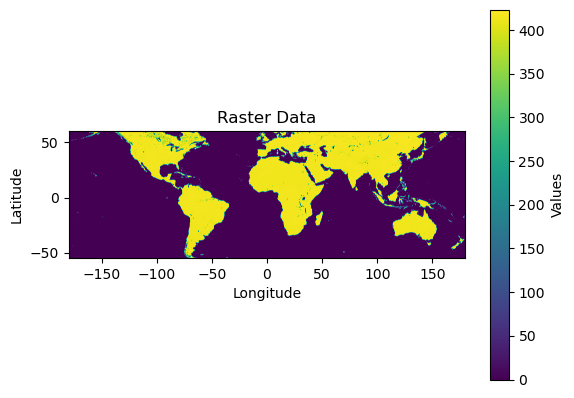

In [ ]:
with rasterio.open(f"Data/202111.nc") as src:
    # Print basic information about the dataset
    print("Dataset Information:")
    print(f"CRS: {src.crs}")
    print(f"Width: {src.width}")
    print(f"Height: {src.height}")
    print(f"Count: {src.count}")
    print(f"Bounds: {src.bounds}")
    print(f"Transform: {src.transform}")
    
    # Print metadata
    print("\nMetadata:")
    print(src.meta)
    
    # Read the first band
    band1 = src.read(1)
    raster_safe = np.where(band1 < 0 , 0, band1)
    
    # Plot the data
    plt.imshow(raster_safe, cmap='viridis', extent=[
        src.bounds.left, src.bounds.right, 
        src.bounds.bottom, src.bounds.top
    ])
    plt.colorbar(label='Values')
    plt.title("Raster Data")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

Total emissions in ind grid: 15850.5
Total emissions in the grid: 15850.5


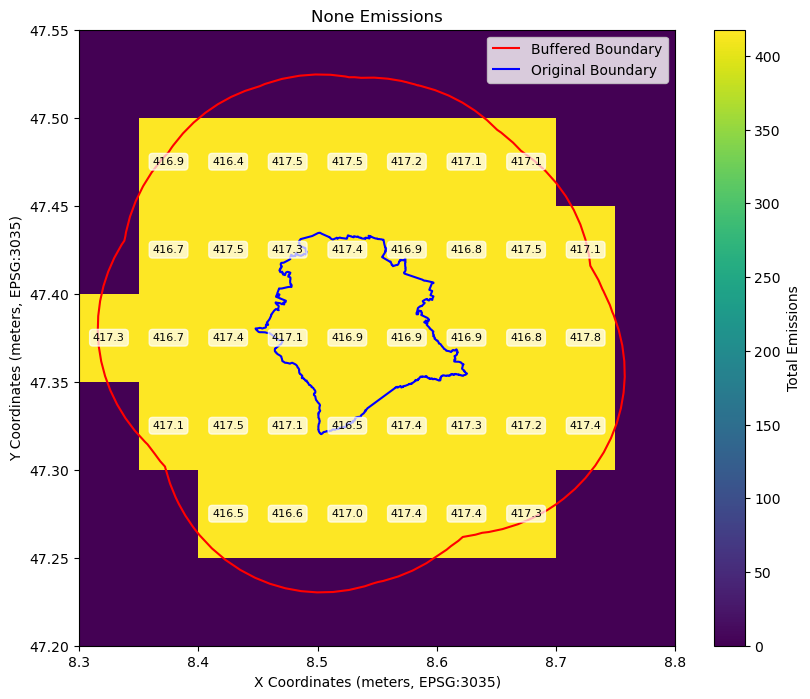

In [262]:

# Default CRS from input files
# assigned_crs = rasterio.CRS.from_epsg(4326)
target_crs = rasterio.crs.CRS.from_epsg(4326)

# Change CRS 
city_gdf_buffered = city_gdf.copy()
city_gdf_buffered["geometry"] = city_gdf.buffer(10000)

city_gdf.to_crs(target_crs, inplace=True) 
city_gdf_buffered.to_crs(target_crs, inplace=True)


with rasterio.open(f"Data/202111.nc", crs=target_crs) as src:

    out_image, out_transform = mask(src, city_gdf_buffered.geometry, crop=True)
    mask_extent = calculate_mask_extent(out_transform, out_image[0].shape)

    # Replace invalid values with a small positive value
    band1 = out_image[0]
    carbon_grid_safe = np.where(band1 > 0, band1, 0)

    print(f"Total emissions in {title} grid: {carbon_grid_safe.sum():.1f}")

    plot_carbon_grid_with_annotations(
        carbon_grid_safe=carbon_grid_safe,
        mask_extent=mask_extent,
        city_gdf=city_gdf,
        city_gdf_buffered=city_gdf_buffered,
        emission_type=None,
        out_transform=out_transform,
        test_raster=None,
        test_extent=None
    )

# Plots

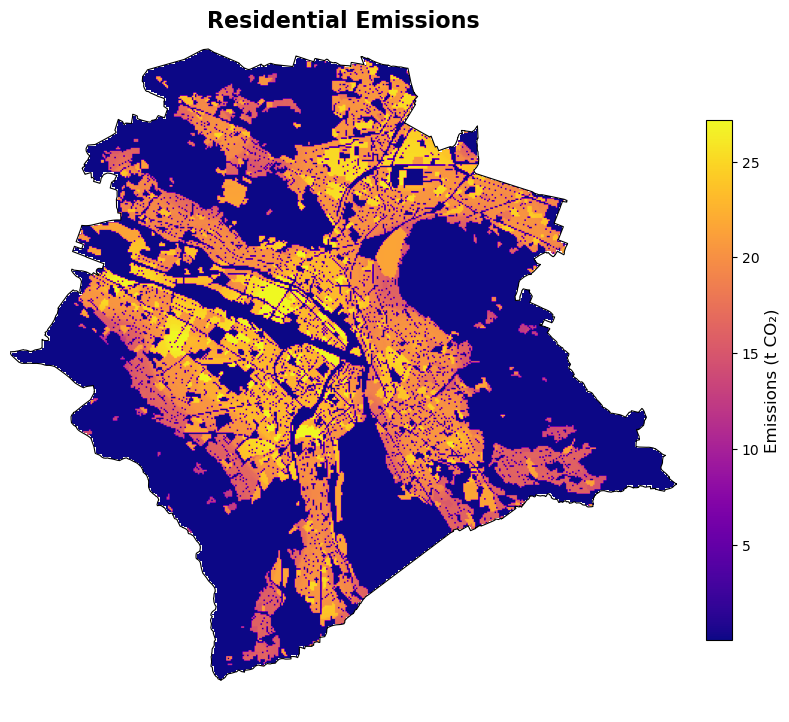

In [11]:
# Your input code
em_type = "res"

with rasterio.open(f"Results/{CITY}/{em_type}_com_emissions_30m.tif") as src:
    # Mask the raster using city_gdf geometry
    masked_raster, mask_transform = mask(
        src,
        city_gdf.geometry,
        crop=False,
        nodata=np.nan
    )
    
    # Set up the plot with enhanced styles
   # Updated plot styling
    fig, ax = plt.subplots(figsize=(8, 8))  # Adjust size for balance

    # Plot the raster with plasma colormap
    im = ax.imshow((masked_raster[0] + 0.01), cmap='plasma', extent=extent)

    # Add city boundary
    city_gdf.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Remove grid, axes labels, and ticks
    ax.axis('off')

    # Add a colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.04)
    cbar.set_label('Emissions (t CO₂)', fontsize=12)

    # Add a clean title
    ax.set_title("Residential Emissions", fontsize=16, weight='bold', pad=15)

    # Save the figure
    plt.tight_layout()
    plt.savefig(f"Results/{CITY}/Figures/res_com_emissions_30m_plasma.png", dpi=300, bbox_inches='tight')
    plt.show()

